# Deep learning project

## Kunskapskontroll 2

### Detecting emotion on images or video of human faces.

To start with we use the following dataset from Kaggle:

'Face expression recognition dataset'

LINK:
https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset

Supplemental dataset from :
    
http://mmlab.ie.cuhk.edu.hk/projects/socialrelation/index.html

The project is based on the example from this Github: https://github.com/akmadan/Emotion_Detection_CNN
 and the Youtube video: https://www.youtube.com/watch?v=Bb4Wvl57LIk

## Importing libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from datetime import datetime
import os
import itertools
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Importing Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import img_to_array,  load_img
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D

from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator 
from keras.layers import Dense, Lambda, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model,Sequential  

from keras.applications.vgg16 import VGG16, preprocess_input #preprocesses the input image to align with the preprocessing used for training the VGG16 model on ImageNet data.

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator



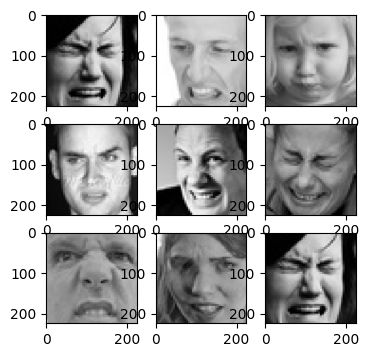

In [2]:
expression = 'disgust'

plt.figure(figsize= (4,4))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img("content/train/"+expression+"/"+
                  os.listdir("content/train/" + expression)[i], target_size=(224, 224))
    plt.imshow(img)   
plt.show()

## Making Training and Validation Data

In [3]:
expressions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [4]:
import os

def count_jpg_files_in_subfolders(root_folder):
    jpg_counts = {}

    subfolders = expressions

    for subfolder in subfolders:
        subfolder_path = os.path.join(root_folder, subfolder)
        jpg_counts[subfolder] = sum(1 for file in os.listdir(subfolder_path) if file.lower().endswith('.jpg'))

    return jpg_counts

# Update the paths to your actual paths
train_path = 'content/train'
test_path = 'content/validation'

train_jpg_counts = count_jpg_files_in_subfolders(train_path)
test_jpg_counts = count_jpg_files_in_subfolders(test_path)

print("JPG counts in train subfolders:")
for subfolder, count in train_jpg_counts.items():
    print(f"{subfolder}: {count} .jpg files")

print("\nJPG counts in test subfolders:")
for subfolder, count in test_jpg_counts.items():
    print(f"{subfolder}: {count} .jpg files")


JPG counts in train subfolders:
Angry: 3993 .jpg files
Disgust: 436 .jpg files
Fear: 4103 .jpg files
Happy: 7164 .jpg files
Neutral: 4982 .jpg files
Sad: 4938 .jpg files
Surprise: 3205 .jpg files

JPG counts in test subfolders:
Angry: 960 .jpg files
Disgust: 111 .jpg files
Fear: 1018 .jpg files
Happy: 1825 .jpg files
Neutral: 1216 .jpg files
Sad: 1139 .jpg files
Surprise: 797 .jpg files


### We need to make training and validation sets. and make sure images are proper size etc.

80% of the images for training and 20% for validation.

In [5]:
train_path = 'content/train'
test_path = 'content/validation'

In [6]:
IMAGE_SIZE = [224, 224]
batch_size = 32

### Test data path.

In [7]:
folders = glob('content/train/*')
print(len(folders))

7


### Preprocess data

In [8]:
import tensorflow as tf

# Define a generator function to load and preprocess the data
def data_generator(dataset, preprocess_fn):
    for image_batch, label_batch in dataset:
        yield preprocess_fn(image_batch, label_batch)

# Load the dataset without preprocessing
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255
)

train_datagen = datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

test_datagen = datagen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 23060 images belonging to 7 classes.
Found 1411 images belonging to 7 classes.


In [9]:
# Desired sizes for the datasets

# Calculate desired training and validation sizes based on 80/20 split
total_train_size = 23060  # Total training dataset size
desired_train_size = int(0.8 * total_train_size)  # 80% of the training data
desired_val_size = total_train_size - desired_train_size  # Remaining for validation

# Print the desired sizes
print("Desired Train Size:", desired_train_size)
print("Desired Validation Size:", desired_val_size)

# Function to split the dataset into training and validation
def split_dataset(generator, desired_train_size, desired_val_size):
    train_images, train_labels = [], []
    val_images, val_labels = [], []
    
    for image_batch, label_batch in generator:
        if len(train_images) < desired_train_size:
            train_images.extend(image_batch)
            train_labels.extend(label_batch)
        elif len(val_images) < desired_val_size:
            val_images.extend(image_batch)
            val_labels.extend(label_batch)
        else:
            break
    
    # Combine images and labels into tuples
    train_dataset = (tf.convert_to_tensor(train_images), tf.convert_to_tensor(train_labels))
    val_dataset = (tf.convert_to_tensor(val_images), tf.convert_to_tensor(val_labels))
    
    return train_dataset, val_dataset

# Split the training dataset into training and validation
train_dataset, val_dataset = split_dataset(train_datagen, desired_train_size, desired_val_size)

# Print the shapes of the datasets
print("Train dataset shape:", train_dataset[0].shape)
print("Validation dataset shape:", val_dataset[0].shape)

Desired Train Size: 18448
Desired Validation Size: 4612
Train dataset shape: (18464, 224, 224, 3)
Validation dataset shape: (4628, 224, 224, 3)


In [10]:
desired_test_size = 1411  # Use the full test dataset
print("Desired Test Size:", desired_test_size)

# Function to create the test dataset without repetition
def create_test_dataset(generator, desired_test_size):
    test_images, test_labels = [], []
    for image_batch, label_batch in generator:
        # Shuffle and select images for the test set
        indices = np.random.choice(len(image_batch), size=min(desired_test_size - len(test_images), len(image_batch)), replace=False)
        test_images.extend(image_batch[indices])
        test_labels.extend(label_batch[indices])
        if len(test_images) == desired_test_size:
            break
    
    # Combine images and labels into tuples
    test_dataset = (np.array(test_images), np.array(test_labels))
    
    return test_dataset

# Create the test dataset
test_dataset = create_test_dataset(test_datagen, desired_test_size)

print("Test dataset shape:", test_dataset[0].shape)

Desired Test Size: 1411
Test dataset shape: (1411, 224, 224, 3)


In [11]:
def count_images_per_category(labels):
    counts = defaultdict(int)
    for label in labels:
        counts[str(np.argmax(label))] += 1
    return counts

# Count images per category in the training dataset
train_category_counts = count_images_per_category(train_dataset[1])

# Count images per category in the validation dataset
val_category_counts = count_images_per_category(val_dataset[1])

# Count images per category in the test dataset
test_category_counts = count_images_per_category(test_dataset[1])

# Print the counts for each dataset
print("Train dataset category counts:")
print(train_category_counts)

print("\nValidation dataset category counts:")
print(val_category_counts)

print("\nTest dataset category counts:")
print(test_category_counts)


Train dataset category counts:
defaultdict(<class 'int'>, {'4': 3188, '3': 4599, '2': 2622, '6': 2103, '5': 3121, '0': 2554, '1': 277})

Validation dataset category counts:
defaultdict(<class 'int'>, {'2': 666, '4': 803, '3': 1142, '5': 835, '6': 465, '0': 644, '1': 73})

Test dataset category counts:
defaultdict(<class 'int'>, {'3': 365, '6': 159, '4': 243, '0': 192, '5': 227, '2': 203, '1': 22})


# VGG16 model preparation and eda

In [12]:
# Load the VGG16 model
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [13]:
# shape and structure of the input data that should be fed into the model during training or inference. 
vgg.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [14]:
# shape and structure of the output data that will be the result.
vgg.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

### We only want the first layers of the bgg16 model

In [15]:
layers = 10

# Extract the first 10 layers from the base model
desired_layers = vgg.layers[:layers]

# Create a new model with only the desired layers
vgg_partial = Model(inputs=vgg.input, outputs=desired_layers[-1].output)

In [16]:
# Freeze the layers in the partial VGG model (optional)
for layer in vgg_partial.layers:
    layer.trainable = False

### Customized model creation

In [17]:
# Custom head for classification

no_of_classes = 7

#1st CNN layer
custom_head = Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(7, 7, 512))(vgg_partial.output)
custom_head = BatchNormalization()(custom_head)
custom_head = MaxPooling2D(pool_size=(2, 2))(custom_head)
custom_head = Dropout(0.25)(custom_head)

#2nd CNN layer
custom_head = Conv2D(128, (5, 5), padding='same', activation='relu')(custom_head)
custom_head = BatchNormalization()(custom_head)
custom_head = MaxPooling2D(pool_size=(2, 2))(custom_head)
custom_head = Dropout(0.25)(custom_head)

# Flatten the output for fully connected layers
custom_head = Flatten()(custom_head)

# Fully connected 1st layer
custom_head = Dense(256, activation='relu')(custom_head)
custom_head = BatchNormalization()(custom_head)
custom_head = Dropout(0.25)(custom_head)

# Fully connected 2nd layer
custom_head = Dense(512, activation='relu')(custom_head)
custom_head = BatchNormalization()(custom_head)
custom_head = Dropout(0.25)(custom_head)

# Last layer
custom_head = Dense(no_of_classes, activation='softmax')(custom_head)


In [18]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='final_model.h5', verbose=2, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
callbacks = [checkpoint, early_stopping]

# timer
start = datetime.now()

# lr
adam = Adam(learning_rate=0.0001)  

In [19]:
# Combine the partial VGG model and the custom head
model = Model(name='hybrid_vgg16_face_emotion_model',inputs=vgg_partial.input, outputs=custom_head)

# Compile the model
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "hybrid_vgg16_face_emotion_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None,

## Fit the model and train it.

In [20]:
epochs = 48

# Unpack the dataset into X_train and y_train
X_train, y_train =  train_dataset

# Unpack the validation dataset into X_val and y_val
X_val, y_val = val_dataset

# Check the shapes of the training data
print("Shapes of training data:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Train the model
epochs = 48
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    steps_per_epoch=500,
    validation_steps=64,
    callbacks=callbacks,
    verbose=1
)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Shapes of training data:
X_train shape: (18464, 224, 224, 3)
y_train shape: (18464, 7)
Epoch 1/48
500/500 [==============================] - ETA: 0s - loss: 2.0073 - accuracy: 0.3325
Epoch 1: val_loss improved from inf to 1.45796, saving model to final_model.h5


C:\Users\asche\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


500/500 [==============================] - 1235s 2s/step - loss: 2.0073 - accuracy: 0.3325 - val_loss: 1.4580 - val_accuracy: 0.4685
Epoch 2/48
500/500 [==============================] - ETA: 0s - loss: 1.5554 - accuracy: 0.4515
Epoch 2: val_loss improved from 1.45796 to 1.35717, saving model to final_model.h5
500/500 [==============================] - 1253s 3s/step - loss: 1.5554 - accuracy: 0.4515 - val_loss: 1.3572 - val_accuracy: 0.5017
Epoch 3/48
500/500 [==============================] - ETA: 0s - loss: 1.3467 - accuracy: 0.5176
Epoch 3: val_loss improved from 1.35717 to 1.35040, saving model to final_model.h5
500/500 [==============================] - 1260s 3s/step - loss: 1.3467 - accuracy: 0.5176 - val_loss: 1.3504 - val_accuracy: 0.5089
Epoch 4/48
500/500 [==============================] - ETA: 0s - loss: 1.1912 - accuracy: 0.5680
Epoch 4: val_loss improved from 1.35040 to 1.34746, saving model to final_model.h5
500/500 [==============================] - 1247s 2s/step - loss:

## Plotting Accuracy & Loss

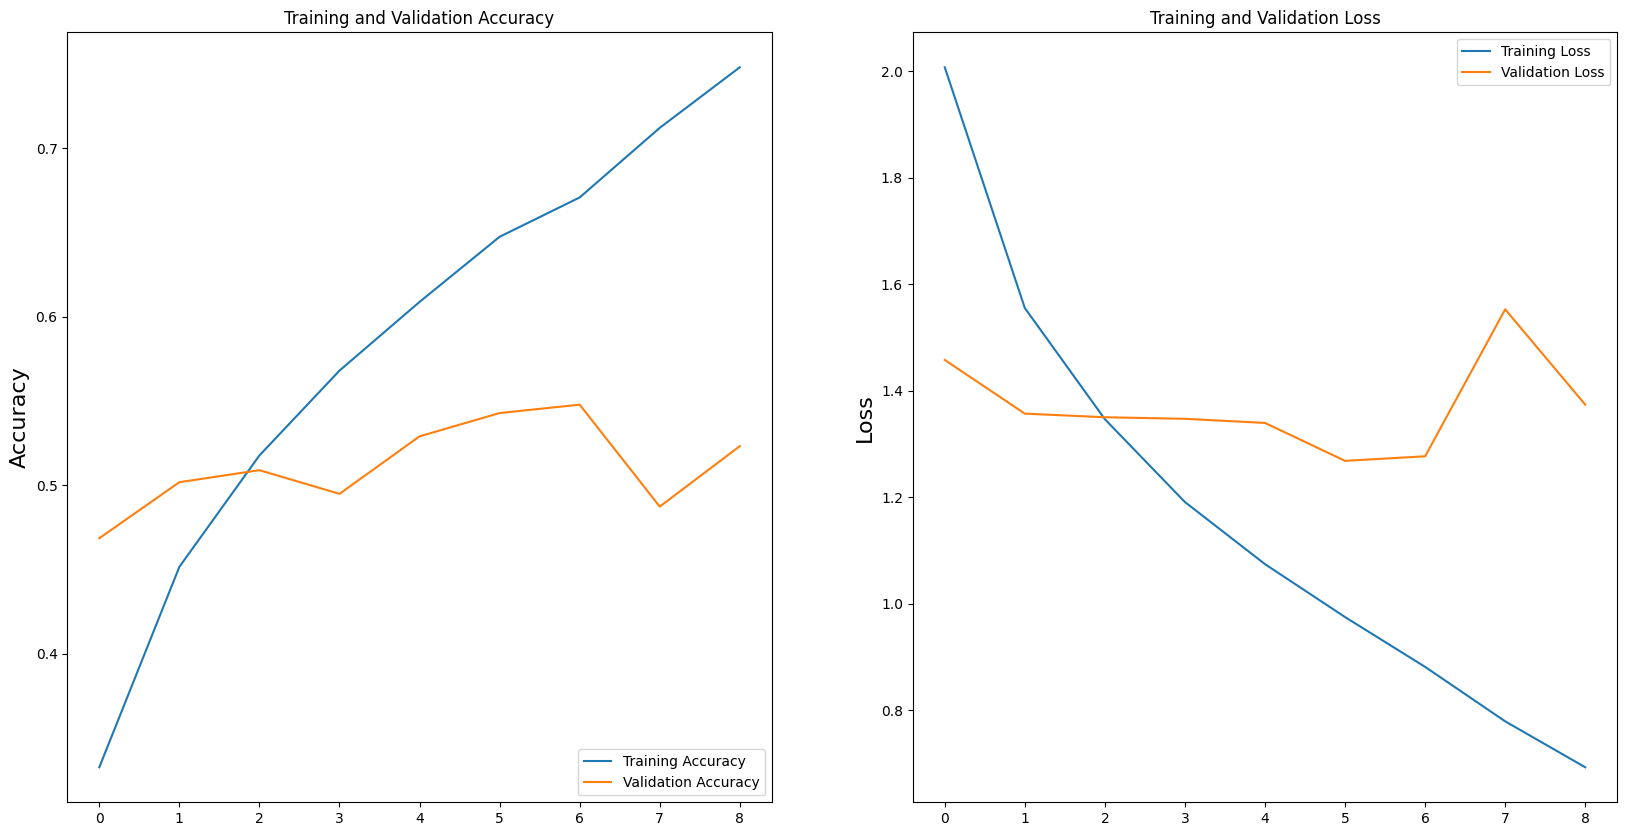

In [21]:
plt.figure(figsize=(20, 10))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training loss
plt.subplot(1, 2, 2)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


45/45 [==============================] - 63s 1s/step


<Figure size 800x800 with 0 Axes>

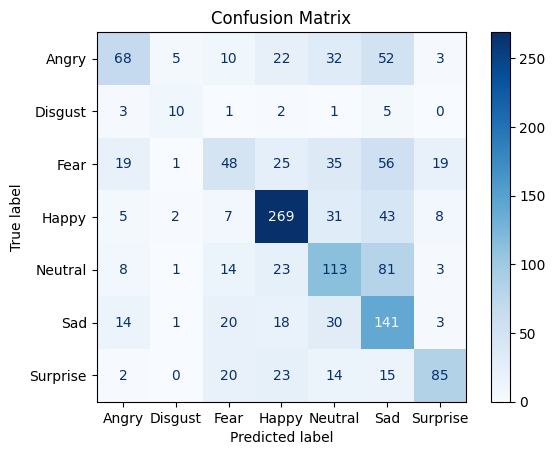

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Unpack the dataset into X_train and y_train
X_test, y_test = test_dataset

# Assuming y_test contains the true labels and y_pred contains the predicted labels
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix
plt.figure(figsize=(8, 8))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=expressions).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# -------------------------------------------------------------------------------------------------# 

#  Create the confusion matrix 
cm = confusion_matrix(y_true, y_pred_classes)

# Change the the confusion matrix to strings/text
cm_str = np.array2string(cm, separator=', ', formatter={'int': lambda x: f'{x: d}'})

print('Confusion Matrix:')
print(cm_str)


### Evaluate the model on the test dataset

In [23]:
test_loss, test_accuracy = model.evaluate(
    x=X_train,
    y=y_train,
)

577/577 [==============================] - 833s 1s/step - loss: 0.5967 - accuracy: 0.8002
Test Loss: 0.5967437624931335
Test Accuracy: 0.8002058267593384


In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(np.argmax(y_test, axis=1), y_pred_classes, average='weighted')
recall = recall_score(np.argmax(y_test, axis=1), y_pred_classes, average='weighted')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred_classes, average='weighted')

# Print the test loss, accuracy, precision, recall, and F1 score
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

45/45 [==============================] - 68s 1s/step
Test Loss: 0.5967437624931335
Test Accuracy: 0.8002058267593384
Precision: 0.5381585848642382
Recall: 0.520198440822112
F1 Score: 0.5155849493858295


# Test the model

A test image from the internet : https://techhowdy.com/wp-content/uploads/2018/05/Cute-Sad-Baby-Pics-For-Whatsapp-Display-Picture-21.jpg

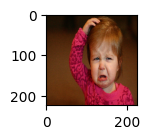

In [27]:
plt.figure(figsize= (4,4))
plt.subplot(3,3,i)
img = load_img('sad_baby.jpg', target_size=(224, 224))
plt.imshow(img)   
plt.show()

In [28]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the image
image_path = 'sad_baby.jpg' 
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV loads images in BGR, convert to RGB

# Resize and preprocess the image
img = cv2.resize(img, (224, 224))
img = img / 255.0  # Normalize the pixel values

# Reshape the image to match the model's input shape
img = np.reshape(img, (1, 224, 224, 3))

# Make predictions
predictions = model.predict(img)

# Assuming you have a mapping of emotion labels (e.g., ['happy', 'sad', 'angry', ...])
emotion_labels = expressions
predicted_emotion = emotion_labels[np.argmax(predictions)]

# Get the index of the maximum prediction
predicted_emotion_index = np.argmax(predictions)

# Get the corresponding emotion label
predicted_emotion = emotion_labels[predicted_emotion_index]

# Print the predicted emotion
print("Predicted Emotion:", predicted_emotion)


1/1 [==============================] - 0s 77ms/step
Predicted Emotion: Sad


In [36]:
# Path to the folder containing images
folder_path = 'test_images'

# Iterate through the images in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(folder_path, filename)
        
        # Load the image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Resize and preprocess the image
        img = cv2.resize(img, (224, 224))
        img = img / 255.0  # Normalize the pixel values

        # Reshape the image to match the model's input shape
        img = np.reshape(img, (1, 224, 224, 3))

        # Make predictions
        predictions = model.predict(img)

        # Get the index of the maximum prediction
        predicted_emotion_index = np.argmax(predictions)

        # Get the corresponding emotion label
        predicted_emotion = expressions[predicted_emotion_index]

        # Print the predicted emotion for this image
        print(f"Predicted Emotion for {filename}: {predicted_emotion}")


1/1 [==============================] - 0s 93ms/step
Predicted Emotion for angry.png: Surprise
1/1 [==============================] - 0s 79ms/step
Predicted Emotion for disgust.png: Surprise
1/1 [==============================] - 0s 86ms/step
Predicted Emotion for happy.png: Happy
1/1 [==============================] - 0s 78ms/step
Predicted Emotion for sad.png: Sad
1/1 [==============================] - 0s 77ms/step
Predicted Emotion for surprise.png: Surprise
